In [1]:
from pathlib import Path
import os
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
import statkit
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import pylab
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.calibration import calibration_curve
import seaborn as sns
from typing import List, Tuple
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


sns.set_theme()

## Predicting Numerical Values with Machine Learning

- MLR
- Lasso regression
- KNN
- Random Forest
- XGBoost

In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------------------------
# 1. Load Data
# ---------------------------
# Load your field mapping that contains "Field Name", "Source", and "Indicator Category"
fieldMapping_df = pd.read_csv('Field Mapping List.csv')
print("Field Mapping Preview:")
print(fieldMapping_df.head())

# Load your cleaned dataset
df = pd.read_csv('Group1DatasetCleaned.csv')

# ---------------------------
# 2. Drop Unwanted Columns
# ---------------------------
# Define initial drop list for essential columns you do not want in predictors
dropList = ['Life expectancy at birth, total (years)', 'CountryShortName', 'Year']

# Identify columns that contain "male" or "female" (ignore case)
cols_to_drop = [col for col in df.columns if 'male' in col.lower() or 'female' in col.lower()]

# Combine the initial dropList with the columns identified above
all_drop_columns = list(set(dropList + cols_to_drop))

# Create the target variable (Y) and a predictor DataFrame (df_predictors) containing all non-dropped columns
Y = df['Life expectancy at birth, total (years)']
df_predictors = df.drop(columns=all_drop_columns)

# ---------------------------
# 3. Create Indicator Category Sets
# ---------------------------
# Get lists of column names from the field mapping for each indicator category.
# (These lists come from the "Field Mapping List.csv" where each row has a "Field Name" and an "Indicator Category".)

env_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Environmental', 'Field Name'])
socio_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Socioeconomic', 'Field Name'])
health_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Health', 'Field Name'])

# Ensure that we only retain those columns which exist in the predictors DataFrame.
env_cols = list(env_cols.intersection(set(df_predictors.columns)))
socio_cols = list(socio_cols.intersection(set(df_predictors.columns)))
health_cols = list(health_cols.intersection(set(df_predictors.columns)))

# Create separate predictor sets for each category
X_env = df_predictors[env_cols]
X_socio = df_predictors[socio_cols]
X_health = df_predictors[health_cols]

print("Environmental columns:")
print(env_cols)
print("\nSocioeconomic columns:")
print(socio_cols)
print("\nHealth columns:")
print(health_cols)

# ---------------------------
# 4. Define VIF Functions with Logging
# ---------------------------
def calculate_vif(df_subset):
    """Calculate VIF for each numerical feature in a DataFrame."""
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_subset.columns
    vif_data["VIF"] = [
        round(variance_inflation_factor(df_subset.values, i), 4) for i in range(df_subset.shape[1])
    ]
    return vif_data

def iterative_vif_drop(X, threshold=4, log_file='vif_dropping_log.txt'):
    """
    Iteratively drop the column with the highest VIF above `threshold`
    until all remaining columns have VIF <= threshold, while logging each drop.
    
    Parameters:
    -----------
    X : DataFrame
        The predictor DataFrame.
    threshold : float
        The maximum acceptable VIF value.
    log_file : str
        The filename where the VIF dropping log will be saved.
    
    Returns:
    --------
    X : DataFrame
        The predictor DataFrame after dropping high-VIF columns.
    """
    log_msgs = []
    while True:
        vif_df = calculate_vif(X)
        max_vif = vif_df["VIF"].max()
        if max_vif > threshold:
            drop_col = vif_df.loc[vif_df["VIF"].idxmax(), "feature"]
            msg = f"Dropping '{drop_col}' with VIF = {max_vif:.2f}"
            print(msg)
            log_msgs.append(msg)
            X = X.drop(columns=[drop_col])
        else:
            break
    # After dropping, log the remaining features.
    remaining = ", ".join(X.columns)
    final_msg = f"Remaining features: {remaining}"
    print(final_msg)
    log_msgs.append(final_msg)
    
    # Save the log messages to a file.
    with open(log_file, 'w') as f:
        for msg in log_msgs:
            f.write(msg + "\n")
            
    return X

# ---------------------------
# 5. Evaluate Each Predictor Set Using VIF with Logging
# ---------------------------
print("\n--- Environmental Predictors VIF ---")
vif_env = calculate_vif(X_env)
print(vif_env)
X_env_reduced = iterative_vif_drop(X_env, threshold=4, log_file='vif_env_log.txt')
print("Final VIF for Environmental predictors:")
print(calculate_vif(X_env_reduced))

print("\n--- Socioeconomic Predictors VIF ---")
vif_socio = calculate_vif(X_socio)
print(vif_socio)
X_socio_reduced = iterative_vif_drop(X_socio, threshold=4, log_file='vif_socio_log.txt')
print("Final VIF for Socioeconomic predictors:")
print(calculate_vif(X_socio_reduced))

print("\n--- Health Predictors VIF ---")
vif_health = calculate_vif(X_health)
print(vif_health)
X_health_reduced = iterative_vif_drop(X_health, threshold=4, log_file='vif_health_log.txt')
print("Final VIF for Health predictors:")
print(calculate_vif(X_health_reduced))


Field Mapping Preview:
                                          Field Name                   Source  \
0    GOAL 13: Climate Action (5 year moving average)             SPIIndicator   
1  Fluorinated greenhouse gases (F-gases) emissio...  WDIEnvironmentIndicator   
2  Total greenhouse gas emissions including LULUC...  WDIEnvironmentIndicator   
3  Carbon dioxide (CO2) net fluxes from LULUCF - ...  WDIEnvironmentIndicator   
4  Carbon dioxide (CO2) net fluxes from LULUCF - ...  WDIEnvironmentIndicator   

  Indicator Category  
0      Environmental  
1      Environmental  
2      Environmental  
3      Environmental  
4      Environmental  
Environmental columns:
['Nitrous oxide (N2O) emissions (total) excluding LULUCF (% change from 1990)', 'Agricultural land (% of land area)', 'Forest rents (% of GDP)', 'Carbon dioxide (CO2) emissions from Building (Energy) (Mt CO2e)', 'Methane (CH4) emissions from Transport (Energy) (Mt CO2e)', 'Carbon intensity of GDP (kg CO2e per constant 2021 US$ 

In [3]:
vif_dropList = [
    "Rural population (% of total population)","Region_South Asia","GDP, PPP (current international $)","Prevalence of anemia among women of reproductive age (% of women ages 15-49)","Total greenhouse gas emissions excluding LULUCF (Mt CO2e)","GNI (current US$)","Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)","Domestic credit to private sector by banks (% of GDP)","Nitrous oxide (N2O) emissions (total) excluding LULUCF (Mt CO2e)","GDP (current US$)","Number of infant deaths","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)","Labor force, total","Methane (CH4) emissions (total) excluding LULUCF (Mt CO2e)","Employment to population ratio, 15+, total (%) (modeled ILO estimate)","Nitrous oxide (N2O) emissions from Industrial Combustion (Energy) (Mt CO2e)","Population ages 0-14, total","Current health expenditure per capita (current US$)","GDP (constant 2015 US$)","Total fisheries production (metric tons)","GNI, Atlas method (current US$)","Surface area (sq. km)","Access to clean fuels and technologies for cooking (% of population)","GDP, PPP (constant 2021 international $)","GDP per capita, PPP (current international $)","Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e)","Number of deaths ages 10-14 years","Number of under-five deaths","Current health expenditure per capita, PPP (current international $)","GDP per capita (current US$)","Employment to population ratio, ages 15-24, total (%) (modeled ILO estimate)","Domestic private health expenditure per capita, PPP (current international $)","Mortality rate, under-5 (per 1,000 live births)","GDP per capita, PPP (constant 2021 international $)","Urban population","Final consumption expenditure (constant 2015 US$)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Carbon dioxide (CO2) emissions from Industrial Combustion (Energy) (Mt CO2e)","GNI per capita, Atlas method (current US$)","Nitrous oxide (N2O) emissions from Agriculture (Mt CO2e)","Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)","Carbon dioxide (CO2) emissions from Power Industry (Energy) (Mt CO2e)","Number of deaths ages 15-19 years","Domestic general government health expenditure per capita (current US$)","Nitrous oxide (N2O) emissions from Waste (Mt CO2e)","Income Group_High income","Lifetime risk of maternal death (%)","Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)","Adjusted net national income (current US$)","Population ages 0-14 (% of total population)","Rural population","People using at least basic sanitation services (% of population)","Total greenhouse gas emissions including LULUCF (Mt CO2e)","GDP growth (annual %)","GNI, PPP (current international $)","Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e)","Mortality rate, infant (per 1,000 live births)","GDP per capita (constant 2015 US$)","Land under cereal production (hectares)","Out-of-pocket expenditure per capita (current US$)","Computer, communications and other services (% of commercial service imports)","Forest area (sq. km)","Number of deaths ages 20-24 years","Carbon dioxide (CO2) emissions from Industrial Processes (Mt CO2e)","Domestic general government health expenditure (% of GDP)","Nitrous oxide (N2O) emissions from Building (Energy) (Mt CO2e)","Prevalence of anemia among pregnant women (%)","Number of deaths ages 5-9 years","Computer, communications and other services (% of commercial service exports)","Methane (CH4) emissions from Agriculture (Mt CO2e)","GNI per capita, PPP (current international $)","Access to electricity (% of population)","Oil rents (% of GDP)","Birth rate, crude (per 1,000 people)","Cereal production (metric tons)","Carbon dioxide (CO2) emissions from Fugitive Emissions (Energy) (Mt CO2e)","Probability of dying among children ages 5-9 years (per 1,000)","Domestic private health expenditure (% of current health expenditure)","Exports of goods, services and primary income (BoP, current US$)","Region_Europe & Central Asia","Adjusted net national income per capita (current US$)","Probability of dying among adolescents ages 15-19 years (per 1,000)","Monetary Sector credit to private sector (% GDP)","Carbon dioxide (CO2) emissions from Building (Energy) (Mt CO2e)","Prevalence of anemia among children (% of children ages 6-59 months)","Methane (CH4) emissions from Waste (Mt CO2e)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Primary education, pupils","School enrollment, primary (% gross)","Crop production index (2014-2016 = 100)","Livestock production index (2014-2016 = 100)","Carbon intensity of GDP (kg CO2e per 2021 PPP $)","Access to clean fuels and technologies for cooking, urban (% of urban population)","People using at least basic sanitation services, rural (% of rural population)","GOAL 17: Partnerships to achieve the Goal (5 year moving average)","Land area (sq. km)","Share of youth not in education, employment or training, total (% of youth population) (modeled ILO estimate)","Fluorinated greenhouse gases (F-gases) emissions from Industrial Processes (Mt CO2e)","People using at least basic drinking water services (% of population)","Travel services (% of commercial service exports)","GDP per person employed (constant 2021 PPP $)","Number of neonatal deaths","General government final consumption expenditure (constant 2015 US$)","People using at least basic drinking water services, urban (% of urban population)","Population ages 15-64 (% of total population)","Immunization, DPT (% of children ages 12-23 months)","Pillar 3 - Data Products - Score","Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)","Access to electricity, urban (% of urban population)","People using at least basic sanitation services, urban (% of urban population)","Import unit value index (2015 = 100)","Immunization, measles (% of children ages 12-23 months)","GOAL 15: Life on Land (5 year moving average)","Women Business and the Law Index Score (scale 1-100)","Domestic general government health expenditure (% of current health expenditure)","Tuberculosis case detection rate (%, all forms)","Food production index (2014-2016 = 100)","Tuberculosis treatment success rate (% of new cases)","Communications, computer, etc. (% of service imports, BoP)","Urban population (% of total population)","Death rate, crude (per 1,000 people)","Export unit value index (2015 = 100)","Self-employed, total (% of total employment) (modeled ILO estimate)","Access to electricity, rural (% of rural population)","Compulsory education, duration (years)","Mortality rate, neonatal (per 1,000 live births)","Labor force participation rate for ages 15-24, total (%) (modeled ILO estimate)","Current health expenditure (% of GDP)","Renewable energy consumption (% of total final energy consumption)","Prevalence of anemia among non-pregnant women (% of women ages 15-49)","GOAL 1: No Poverty (5 year moving average)","GOAL 10: Reduced Inequality (5 year moving average)","Probability of dying among youth ages 20-24 years (per 1,000)","Household Survey on income, etc (Availability score over 10 years)","Inflation, GDP deflator: linked series (annual %)","Adolescent fertility rate (births per 1,000 women ages 15-19)","Out-of-pocket expenditure per capita, PPP (current international $)","Carbon intensity of GDP (kg CO2e per constant 2021 US$ of GDP)","Access to clean fuels and technologies for cooking, rural (% of rural population)","Agricultural land (% of land area)","Nitrous oxide (N2O) emissions from Industrial Processes (Mt CO2e)","GOAL 16: Peace and Justice Strong Institutions (5 year moving average)","Carbon dioxide (CO2) net fluxes from LULUCF - Deforestation (Mt CO2e)","Domestic general government health expenditure per capita, PPP (current international $)","Transport services (% of commercial service imports)","Total natural resources rents (% of GDP)","Broad money (% of GDP)","Adjusted savings: education expenditure (% of GNI)","Pillar 1 - Data Use - Score","Energy intensity level of primary energy (MJ/$2017 PPP GDP)","Methane (CH4) emissions from Industrial Combustion (Energy) (Mt CO2e)","Agriculture, forestry, and fishing, value added (% of GDP)","Probability of dying among adolescents ages 10-14 years (per 1,000)","Methane (CH4) emissions from Power Industry (Energy) (Mt CO2e)","PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)","Prevalence of stunting, height for age (modeled estimate, % of children under 5)","GOAL 11: Sustainable Cities and Communities (5 year moving average)","Income Group_Lower middle income","International tourism, receipts for travel items (current US$)","Preprimary education, duration (years)","Total greenhouse gas emissions excluding LULUCF (% change from 1990)","Methane (CH4) emissions from Building (Energy) (Mt CO2e)","Exports of goods and services (% of GDP)","Domestic credit to private sector (% of GDP)","Methane (CH4) emissions from Transport (Energy) (Mt CO2e)","Maternal mortality ratio (modeled estimate, per 100,000 live births)","Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)","Methane (CH4) emissions from Fugitive Emissions (Energy) (Mt CO2e)","Health/Demographic survey (Availability score over 10 years)","Prevalence of overweight (modeled estimate, % of children under 5)","Out-of-pocket expenditure (% of current health expenditure)","Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)","Urban population growth (annual %)","Forest area (% of land area)","Renewable internal freshwater resources, total (billion cubic meters)","Automated teller machines (ATMs) (per 100,000 adults)","Adjusted savings: carbon dioxide damage (% of GNI)","Proportion of seats held by women in national parliaments (%)","Domestic private health expenditure per capita (current US$)","GOAL 12: Responsible Consumption and Production (5 year moving average)","Nitrous oxide (N2O) emissions from Power Industry (Energy) (Mt CO2e)","Labor Force Survey (Availability score over 10 years)","Fuel imports (% of merchandise imports)","Fuel exports (% of merchandise exports)","Prevalence of undernourishment (% of population)","Arable land (% of land area)","Insurance and financial services (% of commercial service imports)","Region_Sub-Saharan Africa","Communications, computer, etc. (% of service exports, BoP)","Travel services (% of commercial service imports)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)" 
]

# X_reduced = X.drop(vif_dropList, axis=1)

In [4]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# --- Assume that these helper functions have been defined previously ---

def scale_split_data(X, Y, test_size=0.2, random_state=135):
    """
    Convert data to float, perform train-test split,
    scale the data using StandardScaler, and add a constant for the intercept.
    """
    X = X.astype(float)
    Y = Y.astype(float)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    
    # Initialize and fit the StandardScaler on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert scaled arrays back to DataFrames to preserve column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Add a constant to account for the intercept in the regression model
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def fit_ols_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test):
    """
    Fit an OLS regression model using statsmodels, print the model summary,
    perform predictions on the test set, and calculate performance metrics.
    The OLS model summary is also saved to a text log file named "ols_results_log.txt".
    """
    model = sm.OLS(y_train, X_train_scaled).fit()
    
    # Get the model summary as text and print it
    summary_text = model.summary().as_text()
    print(summary_text)
    
    # Save the OLS model summary to a log file (append mode)
    with open("ols_results_log.txt", "a") as f:
        f.write(summary_text + "\n\n")
    
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Test Mean Squared Error:", mse)
    print("Test R-squared:", r2)
    
    results = {"y_pred": y_pred, "mse": mse, "r2": r2}
    return model, results

# fields dropped due to alpha being greater than 0.05
cols_to_remove = [
    "Permanent cropland (% of land area)",
    "Arable land (hectares per person)",
    "Carbon dioxide (CO2) net fluxes from LULUCF - Total excluding non-tropical fires (Mt CO2e)",
    "Carbon dioxide (CO2) net fluxes from LULUCF - Forest Land (Mt CO2e)",
    "Nitrous oxide (N2O) emissions from Fugitive Emissions (Energy) (Mt CO2e)",
    "Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990)",
    "Methane (CH4) emissions (total) excluding LULUCF (% change from 1990)",
    "General government final consumption expenditure (annual % growth)",
    "Region_North America",
    "Official exchange rate (LCU per US$, period average)",
    "Refugee population by country or territory of origin",
    "Net migration",
    "GDP per capita growth (annual %)",
    'Insurance and financial services (% of commercial service exports)',
    'Region_Middle East & North Africa',
    'Refugee population by country or territory of asylum',
    'Transport services (% of commercial service exports)'
]

# --- Update and run the OLS model for each predictor category ---

# 1. Environmental Predictors
print("=== Environmental Predictors Model (After Removing Selected Columns) ===")
X_env_updated = X_env_reduced.drop(columns=cols_to_remove, errors='ignore')
X_train_env, X_test_env, y_train_env, y_test_env = scale_split_data(X_env_updated, Y)
model_env_updated, results_env_updated = fit_ols_and_evaluate(X_train_env, y_train_env, X_test_env, y_test_env)

# 2. Socioeconomic Predictors
print("\n=== Socioeconomic Predictors Model (After Removing Selected Columns) ===")
X_socio_updated = X_socio_reduced.drop(columns=cols_to_remove, errors='ignore')
X_train_socio, X_test_socio, y_train_socio, y_test_socio = scale_split_data(X_socio_updated, Y)
model_socio_updated, results_socio_updated = fit_ols_and_evaluate(X_train_socio, y_train_socio, X_test_socio, y_test_socio)

# 3. Health Predictors
print("\n=== Health Predictors Model (After Removing Selected Columns) ===")
X_health_updated = X_health_reduced.drop(columns=cols_to_remove, errors='ignore')
X_train_health, X_test_health, y_train_health, y_test_health = scale_split_data(X_health_updated, Y)
model_health_updated, results_health_updated = fit_ols_and_evaluate(X_train_health, y_train_health, X_test_health, y_test_health)

# Export Environmental Predictors CSV with Target Variable
export_env = pd.concat([df[['CountryShortName', 'Year', 'Life expectancy at birth, total (years)']], X_env_updated], axis=1)
export_env.to_csv("environmental_predictors.csv", index=False)
print("Environmental predictors exported to environmental_predictors.csv")

# Export Socioeconomic Predictors CSV with Target Variable
export_socio = pd.concat([df[['CountryShortName', 'Year', 'Life expectancy at birth, total (years)']], X_socio_updated], axis=1)
export_socio.to_csv("socioeconomic_predictors.csv", index=False)
print("Socioeconomic predictors exported to socioeconomic_predictors.csv")

# Export Health Predictors CSV with Target Variable
export_health = pd.concat([df[['CountryShortName', 'Year', 'Life expectancy at birth, total (years)']], X_health_updated], axis=1)
export_health.to_csv("health_predictors.csv", index=False)
print("Health predictors exported to health_predictors.csv")


=== Environmental Predictors Model (After Removing Selected Columns) ===
                                       OLS Regression Results                                      
Dep. Variable:     Life expectancy at birth, total (years)   R-squared:                       0.665
Model:                                                 OLS   Adj. R-squared:                  0.662
Method:                                      Least Squares   F-statistic:                     252.4
Date:                                     Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                                             18:03:02   Log-Likelihood:                -6912.8
No. Observations:                                     2308   AIC:                         1.386e+04
Df Residuals:                                         2289   BIC:                         1.397e+04
Df Model:                                               18                                         
Covariance Type:           

In [5]:
# saving used model fields
health_fields = pd.DataFrame(X_health_updated.columns.to_list())
env_fields = pd.DataFrame(X_env_updated.columns.to_list())
socio_fields = pd.DataFrame(X_socio_updated.columns.to_list())

health_fields.to_csv('health_fields.csv')
env_fields.to_csv('env_fields.csv')
socio_fields.to_csv('socio_fields.csv')

Category: Environmental


========== Environmental - Linear Regression ==========
Test MSE: 23.910611553637196
Test R²: 0.6639932265013572
Test MAE: 3.676561584111817
Test RMSE: 4.8898478047519225
Test Median AE: 2.782946210092476
Explained Variance: 0.6642811400366806
Adjusted R²: 0.648138097443345
Cross-validated RMSE: 4.855383751717147
========== Environmental - Ridge Regression ==========
Test MSE: 23.908927123590367
Test R²: 0.6640168971592133
Test MAE: 3.676492261588194
Test RMSE: 4.889675564246606
Test Median AE: 2.784368408129019
Explained Variance: 0.6643037119309381
Adjusted R²: 0.6481628850469439
Cross-validated RMSE: 4.855327845694036
========== Environmental - Lasso Regression ==========
Test MSE: 23.85520300545904
Test R²: 0.6647718618556149
Test MAE: 3.651711660725873
Test RMSE: 4.884178846588139
Test Median AE: 2.7104652632024084
Explained Variance: 0.6648964715338744
Adjusted R²: 0.6489534742117782
Cross-validated RMSE: 4.879913196310994
========== Environmental - ElasticNet Regression ========

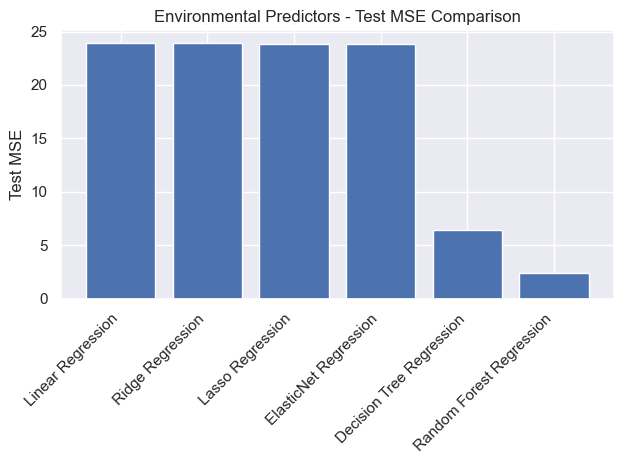


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression 23.910612
        Ridge Regression 23.908927
        Lasso Regression 23.855203
   ElasticNet Regression 23.829023
Decision Tree Regression  6.398181
Random Forest Regression  2.360507




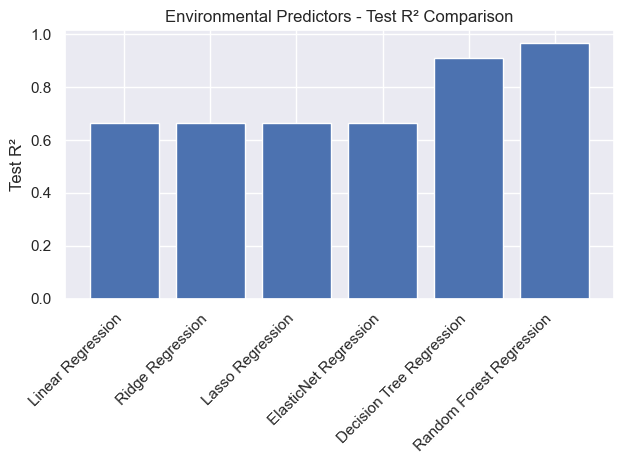


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.663993
        Ridge Regression 0.664017
        Lasso Regression 0.664772
   ElasticNet Regression 0.665140
Decision Tree Regression 0.910089
Random Forest Regression 0.966829




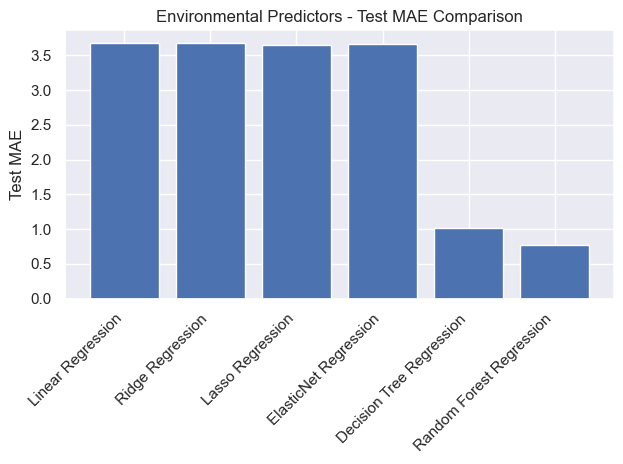


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  3.676562
        Ridge Regression  3.676492
        Lasso Regression  3.651712
   ElasticNet Regression  3.664009
Decision Tree Regression  1.021964
Random Forest Regression  0.767143




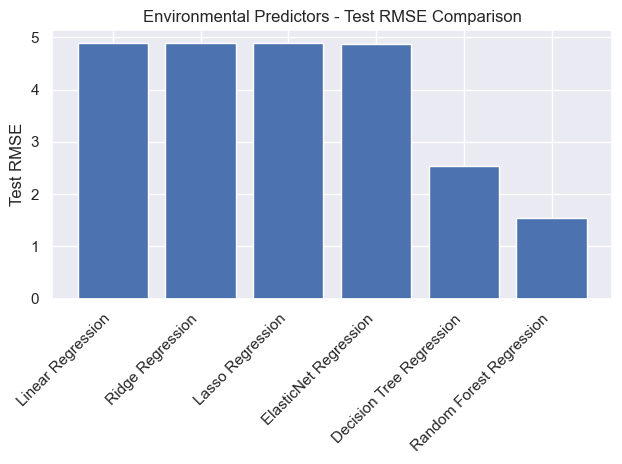


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   4.889848
        Ridge Regression   4.889676
        Lasso Regression   4.884179
   ElasticNet Regression   4.881498
Decision Tree Regression   2.529463
Random Forest Regression   1.536394




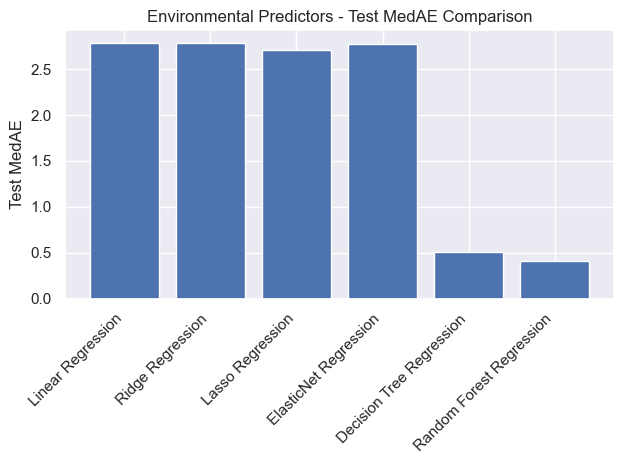


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    2.782946
        Ridge Regression    2.784368
        Lasso Regression    2.710465
   ElasticNet Regression    2.773319
Decision Tree Regression    0.503220
Random Forest Regression    0.403672




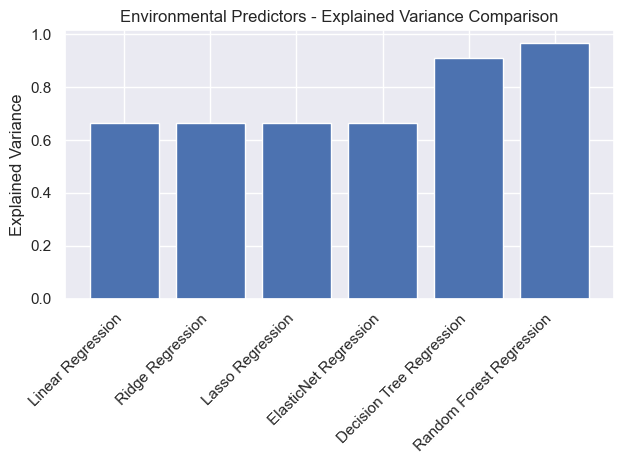


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.664281
        Ridge Regression            0.664304
        Lasso Regression            0.664896
   ElasticNet Regression            0.665265
Decision Tree Regression            0.910222
Random Forest Regression            0.967094




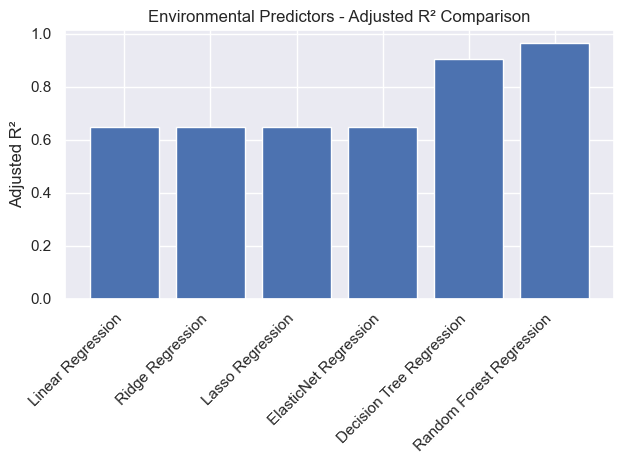


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.648138
        Ridge Regression     0.648163
        Lasso Regression     0.648953
   ElasticNet Regression     0.649339
Decision Tree Regression     0.905846
Random Forest Regression     0.965263




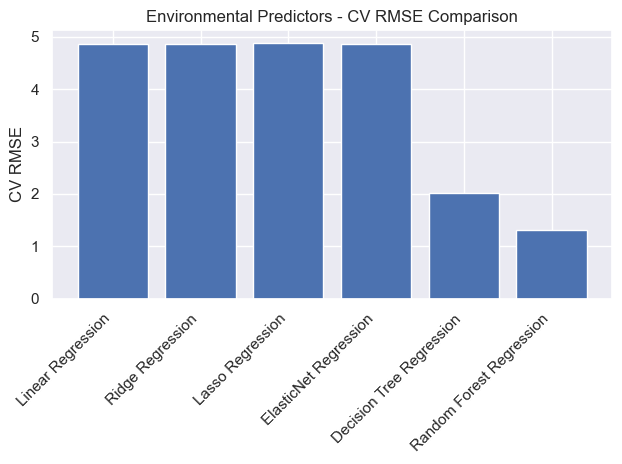


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 4.855384
        Ridge Regression 4.855328
        Lasso Regression 4.879913
   ElasticNet Regression 4.871529
Decision Tree Regression 2.020970
Random Forest Regression 1.314320




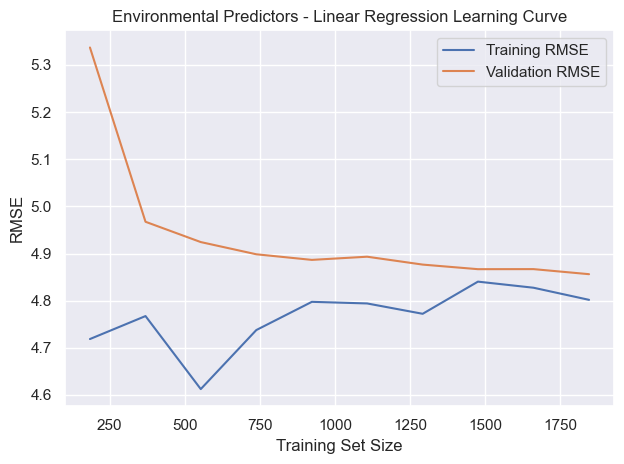

Category: Socioeconomic
========== Socioeconomic - Linear Regression ==========
Test MSE: 15.28447771755383
Test R²: 0.7852130201284651
Test MAE: 2.9477107219671352
Test RMSE: 3.9095367650853254
Test Median AE: 2.378367404764944
Explained Variance: 0.7860831407717055
Adjusted R²: 0.7730181549709236
Cross-validated RMSE: 3.7309108874456656
========== Socioeconomic - Ridge Regression ==========
Test MSE: 15.28480478387998
Test R²: 0.7852084239891851
Test MAE: 2.9478154236249505
Test RMSE: 3.9095785941556387
Test Median AE: 2.3789825741583215
Explained Variance: 0.7860767489511381
Adjusted R²: 0.773013297878681
Cross-validated RMSE: 3.7308571646567095
========== Socioeconomic - Lasso Regression ==========
Test MSE: 15.687579334633156
Test R²: 0.7795483856860095
Test MAE: 2.9663623170920306
Test RMSE: 3.9607548945413367
Test Median AE: 2.312931792602704
Explained Variance: 0.7804298303039588
Adjusted R²: 0.7670319020894276
Cross-validated RMSE: 3.7524419953932893
========== Socioeconomic -

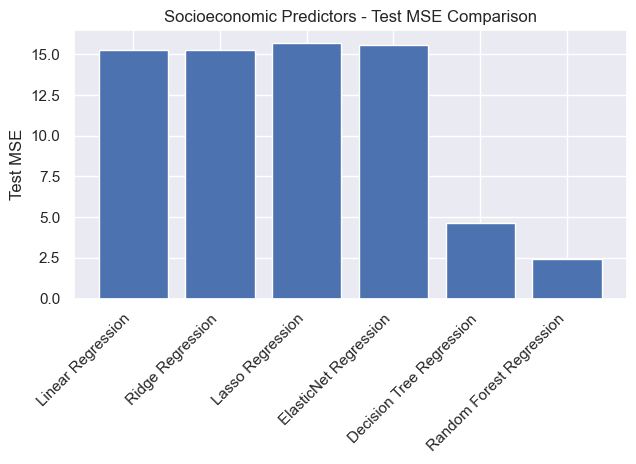


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression 15.284478
        Ridge Regression 15.284805
        Lasso Regression 15.687579
   ElasticNet Regression 15.558589
Decision Tree Regression  4.624552
Random Forest Regression  2.453736




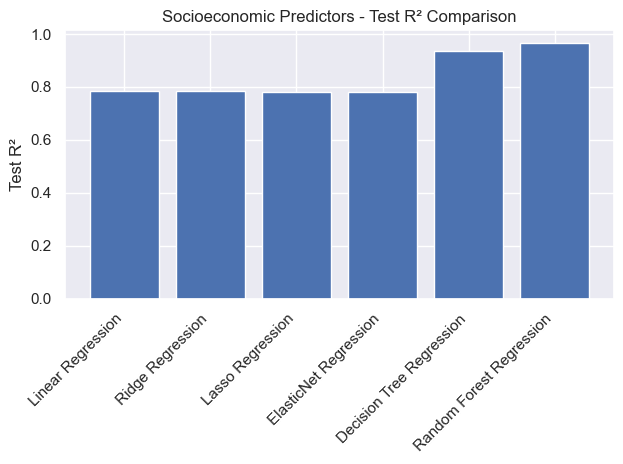


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.785213
        Ridge Regression 0.785208
        Lasso Regression 0.779548
   ElasticNet Regression 0.781361
Decision Tree Regression 0.935013
Random Forest Regression 0.965519




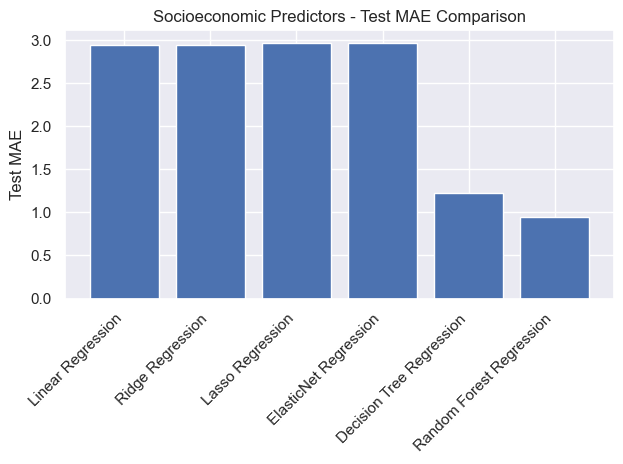


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  2.947711
        Ridge Regression  2.947815
        Lasso Regression  2.966362
   ElasticNet Regression  2.964953
Decision Tree Regression  1.226511
Random Forest Regression  0.941748




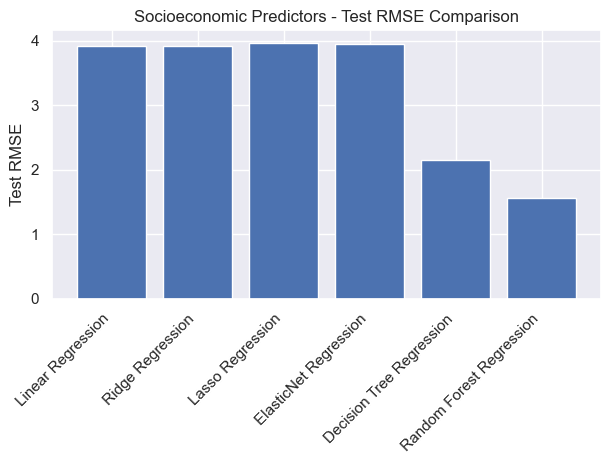


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   3.909537
        Ridge Regression   3.909579
        Lasso Regression   3.960755
   ElasticNet Regression   3.944438
Decision Tree Regression   2.150477
Random Forest Regression   1.566441




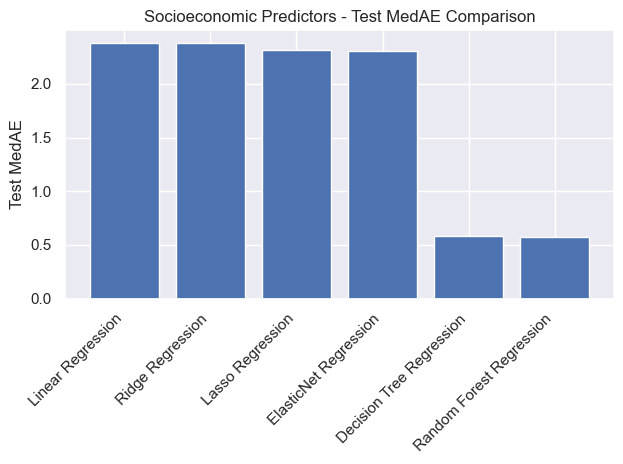


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    2.378367
        Ridge Regression    2.378983
        Lasso Regression    2.312932
   ElasticNet Regression    2.304779
Decision Tree Regression    0.581000
Random Forest Regression    0.575049




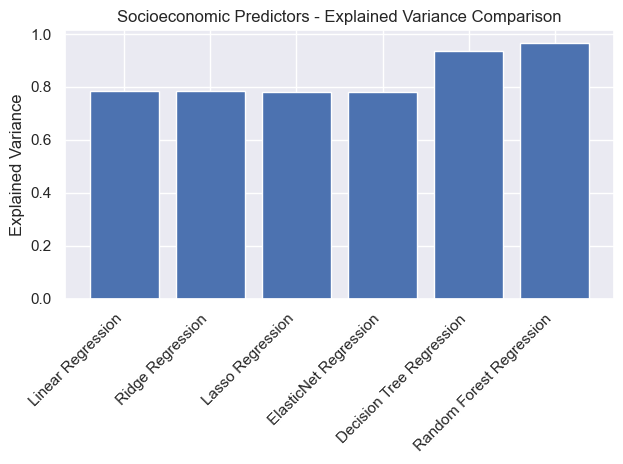


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.786083
        Ridge Regression            0.786077
        Lasso Regression            0.780430
   ElasticNet Regression            0.782093
Decision Tree Regression            0.935221
Random Forest Regression            0.965750




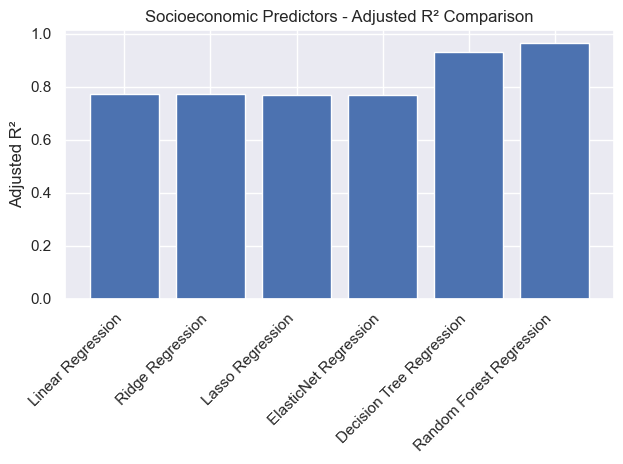


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.773018
        Ridge Regression     0.773013
        Lasso Regression     0.767032
   ElasticNet Regression     0.768947
Decision Tree Regression     0.931323
Random Forest Regression     0.963561




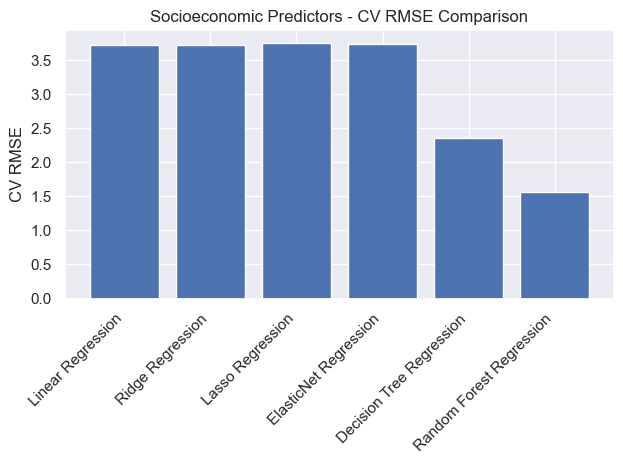


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 3.730911
        Ridge Regression 3.730857
        Lasso Regression 3.752442
   ElasticNet Regression 3.746136
Decision Tree Regression 2.362066
Random Forest Regression 1.571670




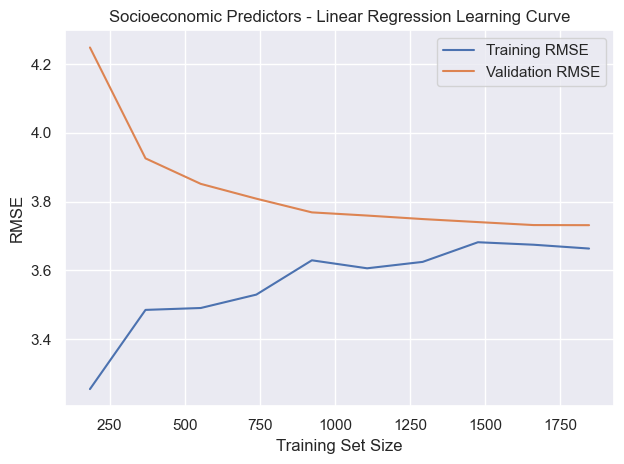

Category: Health
========== Health - Linear Regression ==========
Test MSE: 8.931779663912963
Test R²: 0.8744850812477164
Test MAE: 2.3308927479672876
Test RMSE: 2.988608315573147
Test Median AE: 1.9169471787768764
Explained Variance: 0.8749664228219094
Adjusted R²: 0.8720457453709052
Cross-validated RMSE: 2.9093715500285735
========== Health - Ridge Regression ==========
Test MSE: 8.930734483447264
Test R²: 0.8744997687731783
Test MAE: 2.330788204801543
Test RMSE: 2.9884334497270078
Test Median AE: 1.9146501739392576
Explained Variance: 0.8749815297847008
Adjusted R²: 0.872060718342975
Cross-validated RMSE: 2.9093337273929594
========== Health - Lasso Regression ==========
Test MSE: 8.919888785787991
Test R²: 0.8746521792570615
Test MAE: 2.331353422641432
Test RMSE: 2.986618285919376
Test Median AE: 1.9410799094460351
Explained Variance: 0.8751918303206984
Adjusted R²: 0.8722160908680645
Cross-validated RMSE: 2.929895695723856
========== Health - ElasticNet Regression ==========
Test 

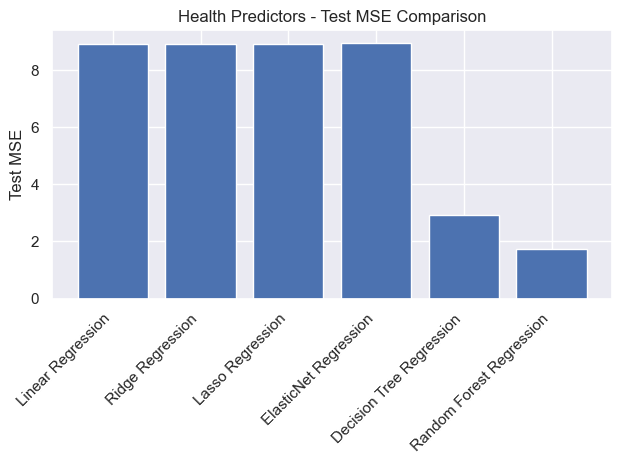


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression  8.931780
        Ridge Regression  8.930734
        Lasso Regression  8.919889
   ElasticNet Regression  8.948243
Decision Tree Regression  2.909869
Random Forest Regression  1.729814




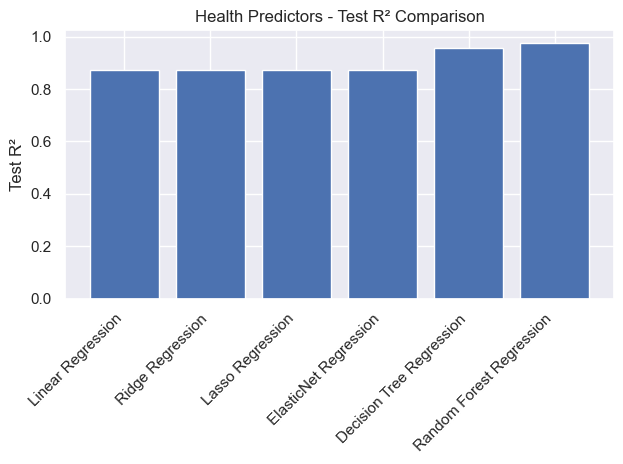


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.874485
        Ridge Regression 0.874500
        Lasso Regression 0.874652
   ElasticNet Regression 0.874254
Decision Tree Regression 0.959109
Random Forest Regression 0.975692




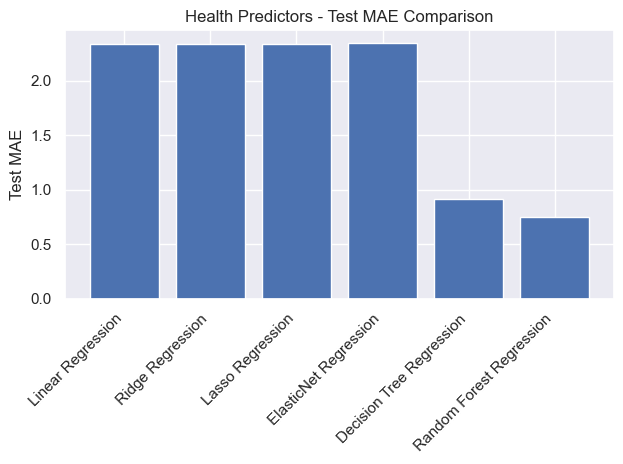


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  2.330893
        Ridge Regression  2.330788
        Lasso Regression  2.331353
   ElasticNet Regression  2.342444
Decision Tree Regression  0.917152
Random Forest Regression  0.751105




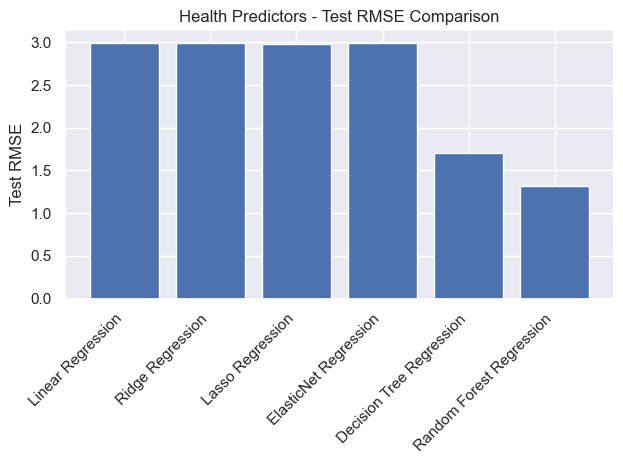


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   2.988608
        Ridge Regression   2.988433
        Lasso Regression   2.986618
   ElasticNet Regression   2.991361
Decision Tree Regression   1.705834
Random Forest Regression   1.315224




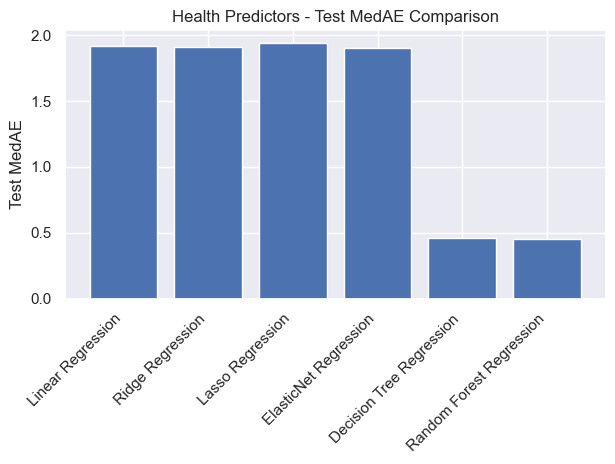


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    1.916947
        Ridge Regression    1.914650
        Lasso Regression    1.941080
   ElasticNet Regression    1.906883
Decision Tree Regression    0.457317
Random Forest Regression    0.448615




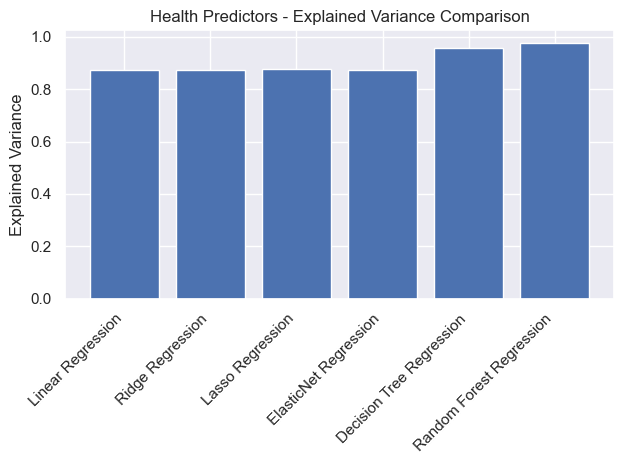


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.874966
        Ridge Regression            0.874982
        Lasso Regression            0.875192
   ElasticNet Regression            0.874784
Decision Tree Regression            0.959133
Random Forest Regression            0.975760




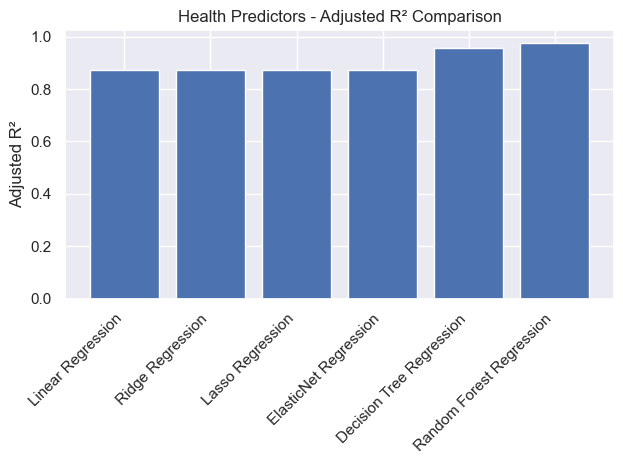


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.872046
        Ridge Regression     0.872061
        Lasso Regression     0.872216
   ElasticNet Regression     0.871810
Decision Tree Regression     0.958314
Random Forest Regression     0.975219




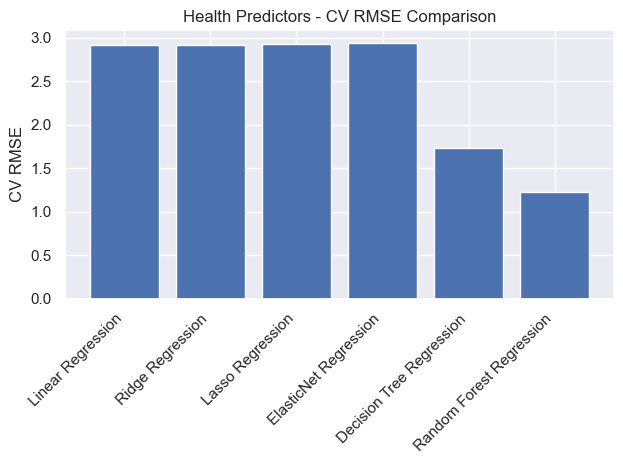


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 2.909372
        Ridge Regression 2.909334
        Lasso Regression 2.929896
   ElasticNet Regression 2.935729
Decision Tree Regression 1.725842
Random Forest Regression 1.222676




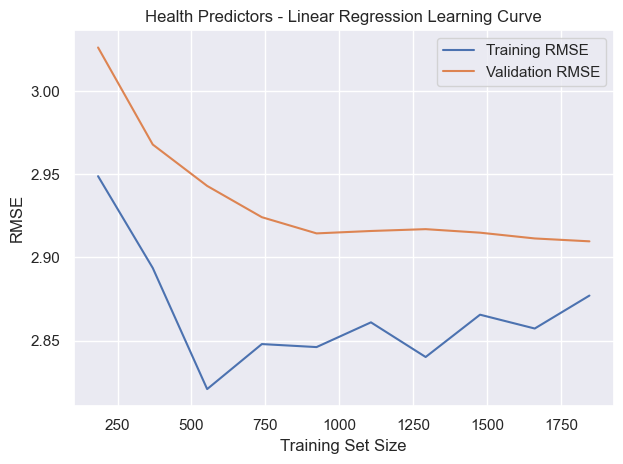

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             median_absolute_error, explained_variance_score)
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler

# ===============================================================
# Modified evaluation function that returns a dictionary of metrics
# ===============================================================
def evaluate_model(model, full_name, X_train, y_train, X_test, y_test, plot=True):
    # Fit the model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute various evaluation metrics
    mse    = mean_squared_error(y_test, y_pred)
    r2     = r2_score(y_test, y_pred)
    mae    = mean_absolute_error(y_test, y_pred)
    rmse   = np.sqrt(mse)
    medae  = median_absolute_error(y_test, y_pred)
    evs    = explained_variance_score(y_test, y_pred)
    n      = len(y_test)
    p      = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # 5-fold cross-validation RMSE on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse   = np.sqrt(-cv_scores).mean()
    
    # Optionally plot a residual plot
    if plot:
        residuals = y_test - y_pred
        plt.figure()
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.axhline(0, color='black', linestyle='--')
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title(f"Residual Plot - {full_name}")
        plt.show()
    
    # Print a summary for the model
    print(f"========== {full_name} ==========")
    print("Test MSE:", mse)
    print("Test R²:", r2)
    print("Test MAE:", mae)
    print("Test RMSE:", rmse)
    print("Test Median AE:", medae)
    print("Explained Variance:", evs)
    print("Adjusted R²:", adjusted_r2)
    print("Cross-validated RMSE:", cv_rmse)
    
    return {
       "Model": "",  # Will be overwritten in the pipeline function
       "Test MSE": mse,
       "Test R²": r2,
       "Test MAE": mae,
       "Test RMSE": rmse,
       "Test MedAE": medae,
       "Explained Variance": evs,
       "Adjusted R²": adjusted_r2,
       "CV RMSE": cv_rmse
    }

# ===============================================================
# Pipeline function for splitting, scaling, evaluating, and summarizing
# ===============================================================
def run_model_pipeline(X, Y, category_name, test_size=0.2, random_state=135):
    """
    Processes predictor set X for a given category:
      - Converts to floats, splits into train and test,
      - Scales data and adds a constant,
      - Fits multiple regression models,
      - Collects key evaluation metrics,
      - Plots summary bar charts for all metrics and then prints a table (in text) for the metric,
      - Plots a learning curve for Linear Regression.
      
    Parameters:
        X (DataFrame): Predictor features for the category.
        Y (Series): Target variable.
        category_name (str): e.g., "Environmental".
        test_size (float): Proportion for testing.
        random_state (int): Seed for reproducibility.
        
    Returns:
        summary_df (DataFrame): A summary table of evaluation metrics for each model.
    """
    # Convert data type to float
    X = X.astype(float)
    Y = Y.astype(float)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    
    # Scale the predictors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # Convert back to DataFrame to retain column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Add a constant for the intercept
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled  = sm.add_constant(X_test_scaled)
    
    print("================================")
    print(f"Category: {category_name}")
    print("================================")
    
    # Define regression models and their short names for summaries
    models = [
       (LinearRegression(),         "Linear Regression"),
       (Ridge(alpha=1.0),          "Ridge Regression"),
       (Lasso(alpha=0.1),          "Lasso Regression"),
       (ElasticNet(alpha=0.1, l1_ratio=0.5),  "ElasticNet Regression"),
       (DecisionTreeRegressor(random_state=42), "Decision Tree Regression"),
       (RandomForestRegressor(random_state=42), "Random Forest Regression")
    ]
    
    # Evaluate each model and collect metrics
    results_summary = []
    for model, short_name in models:
       full_name = f"{category_name} - {short_name}"
       metrics_dict = evaluate_model(
           model, full_name, X_train_scaled, y_train, X_test_scaled, y_test, plot=False
       )
       metrics_dict["Model"] = short_name  # Overwrite with short name only
       results_summary.append(metrics_dict)
       
    # Create a summary DataFrame
    summary_df = pd.DataFrame(results_summary)
    print("\nSummary of Evaluation Metrics:")
    print(summary_df)
    
    # List of metrics to plot and print a table below the figure
    metric_names = ["Test MSE", "Test R²", "Test MAE", "Test RMSE", "Test MedAE", "Explained Variance", "Adjusted R²", "CV RMSE"]
    
    # Loop over each metric to create a bar chart and then print a table
    for metric in metric_names:
        plt.bar(summary_df["Model"], summary_df[metric])
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{category_name} Predictors - {metric} Comparison")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()
        
        # Print the summary table for this metric
        print(f"\nSummary Table for {metric}:")
        print(summary_df[["Model", metric]].to_string(index=False))
        print("\n")
    
    # Additionally, plot a learning curve for Linear Regression only
    train_sizes, train_scores, valid_scores = learning_curve(
       estimator=LinearRegression(),
       X=X_train_scaled,
       y=y_train,
       train_sizes=np.linspace(0.1, 1.0, 10),
       cv=5,
       scoring='neg_mean_squared_error'
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    valid_rmse = np.sqrt(-valid_scores.mean(axis=1))
    plt.plot(train_sizes, train_rmse, label='Training RMSE')
    plt.plot(train_sizes, valid_rmse, label='Validation RMSE')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'{category_name} Predictors - Linear Regression Learning Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return summary_df

# ===============================================================
# Example Usage:
# (Make sure you have defined your reduced predictor sets and Y)
#
summary_env    = run_model_pipeline(X_env_reduced, Y, "Environmental")
summary_socio  = run_model_pipeline(X_socio_reduced, Y, "Socioeconomic")
summary_health = run_model_pipeline(X_health_reduced, Y, "Health")


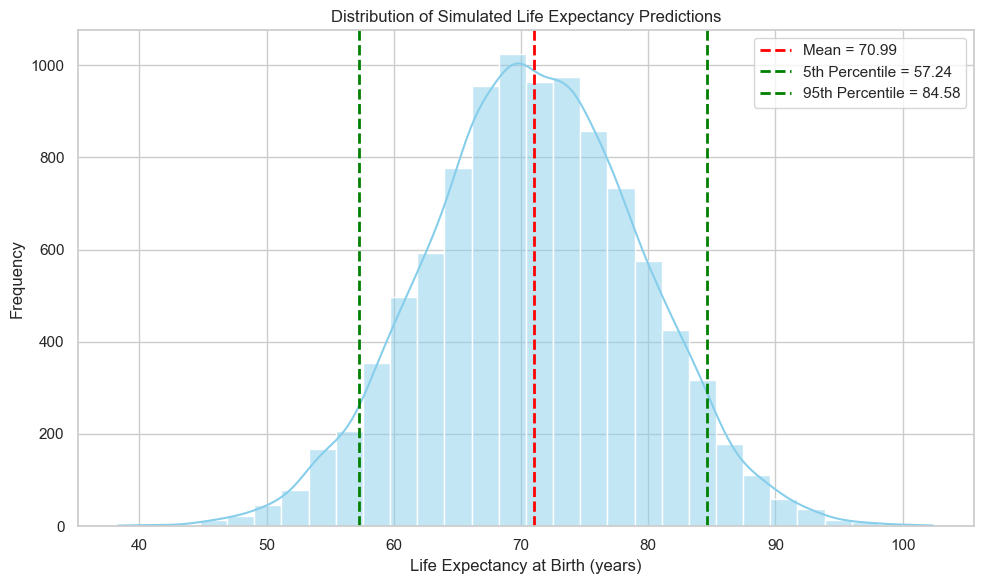

Environmental scenario summary: {'mean_LE': 70.98818332282778, '5th_percentile': 57.23975084438167, '95th_percentile': 84.58143895037614}


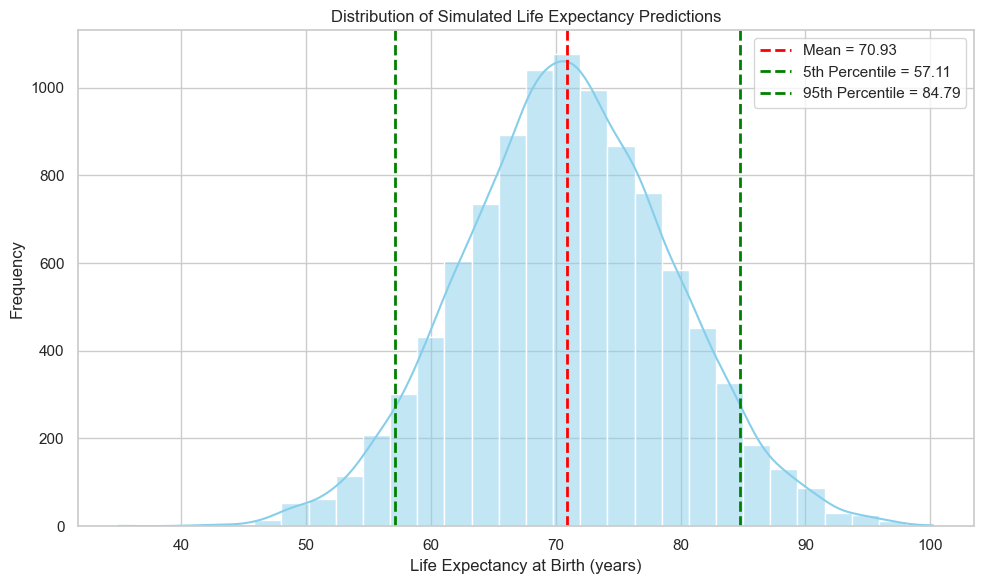

Socioeconomic scenario summary: {'mean_LE': 70.93199500825654, '5th_percentile': 57.106415788300104, '95th_percentile': 84.78748028751613}


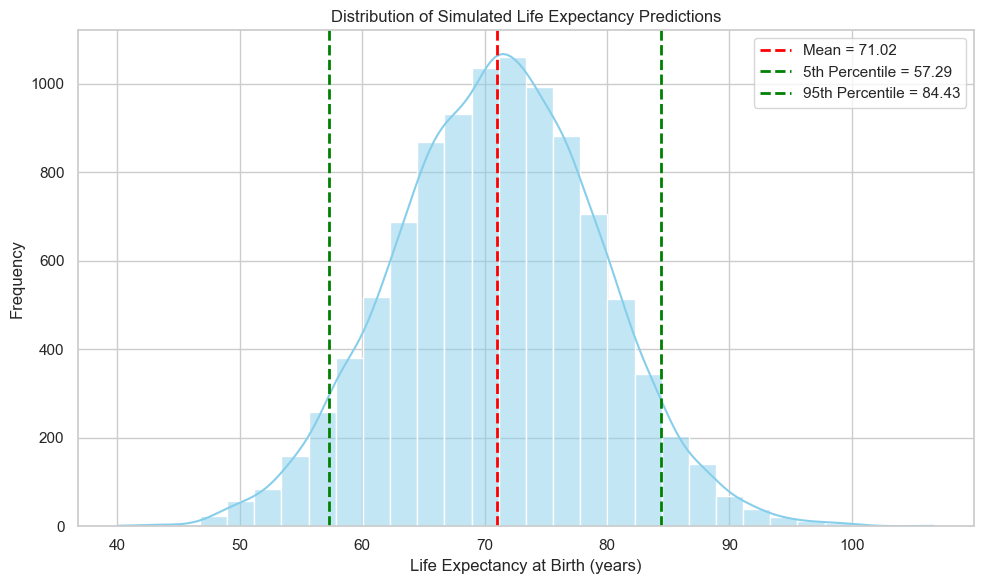

Health scenario summary: {'mean_LE': 71.01750983470062, '5th_percentile': 57.286347857345845, '95th_percentile': 84.42696037066}


In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def simulate_life_expectancy(model, X_train_scaled, n_sim=10000, random_state=42, plot=True):
    """
    Simulate life expectancy predictions based on a fitted OLS model using a Monte Carlo approach.
    
    This function uses the distribution of the predictors (derived from the scaled training data)
    and the model's residual variance to generate simulated life expectancy outcomes.
    
    Parameters:
    -----------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        The fitted OLS model.
    X_train_scaled : DataFrame
        The scaled training predictors including the constant (if available).
    n_sim : int, default 10000
        The number of simulation iterations.
    random_state : int, default 42
        Random seed for reproducibility.
    plot : bool, default True
        Whether to plot the distribution of simulated life expectancy outcomes.
    
    Returns:
    --------
    simulated_LE : ndarray
        An array of simulated life expectancy predictions.
    summary : dict
        A dictionary summarizing the simulations: mean, 5th percentile, and 95th percentile.
    """
    # Set the random seed for reproducibility
    np.random.seed(random_state)
    
    # If a constant is included, remove it to compute the distribution of predictors.
    if "const" in X_train_scaled.columns:
        features = X_train_scaled.drop(columns="const")
    else:
        features = X_train_scaled.copy()
    
    # Calculate the mean vector and covariance matrix of predictors
    mu = features.mean().values
    Sigma = features.cov().values
    
    # Extract model parameters (including the intercept)
    params = model.params.values

    # Estimate the standard deviation of the residuals (model error)
    sigma_resid = np.sqrt(np.mean(model.resid**2))
    
    # Run Monte Carlo simulation for n_sim iterations
    simulated_LE = []
    for i in range(n_sim):
        # Sample predictor values from the multivariate normal distribution
        sim_x = np.random.multivariate_normal(mu, Sigma)
        # Prepend a constant term (1) to match the model inputs
        sim_input = np.concatenate(([1], sim_x))
        # Compute the predicted LEB and add a random error term
        pred_LE = np.dot(sim_input, params) + np.random.normal(0, sigma_resid)
        simulated_LE.append(pred_LE)
    
    simulated_LE = np.array(simulated_LE)
    
    # Compute summary statistics: mean, 5th, and 95th percentiles
    mean_LE = np.mean(simulated_LE)
    lower_LE = np.percentile(simulated_LE, 5)
    upper_LE = np.percentile(simulated_LE, 95)
    summary = {"mean_LE": mean_LE, "5th_percentile": lower_LE, "95th_percentile": upper_LE}
    
    # Plot the distribution using Seaborn
    if plot:
        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))
        sns.histplot(simulated_LE, kde=True, bins=30, color="skyblue")
        plt.axvline(mean_LE, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_LE:.2f}')
        plt.axvline(lower_LE, color='green', linestyle='--', linewidth=2, label=f'5th Percentile = {lower_LE:.2f}')
        plt.axvline(upper_LE, color='green', linestyle='--', linewidth=2, label=f'95th Percentile = {upper_LE:.2f}')
        plt.title("Distribution of Simulated Life Expectancy Predictions")
        plt.xlabel("Life Expectancy at Birth (years)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return simulated_LE, summary

# Example usage: (Assuming you have already fitted OLS models for each predictor category
# such as model_env_updated, model_socio_updated, and model_health_updated,
# along with their training data: X_train_env, X_train_socio, and X_train_health)

# Environmental scenario simulation:
sim_env, summary_env = simulate_life_expectancy(model_env_updated, X_train_env, n_sim=10000, random_state=42, plot=True)
print("Environmental scenario summary:", summary_env)

# Socioeconomic scenario simulation:
sim_socio, summary_socio = simulate_life_expectancy(model_socio_updated, X_train_socio, n_sim=10000, random_state=42, plot=True)
print("Socioeconomic scenario summary:", summary_socio)

# Health scenario simulation:
sim_health, summary_health = simulate_life_expectancy(model_health_updated, X_train_health, n_sim=10000, random_state=42, plot=True)
print("Health scenario summary:", summary_health)


Simulated Life Expectancy at Birth (LEB):
Mean = 57.797843975129815
5th Percentile = 54.106145289711435
95th Percentile = 61.44035059637343


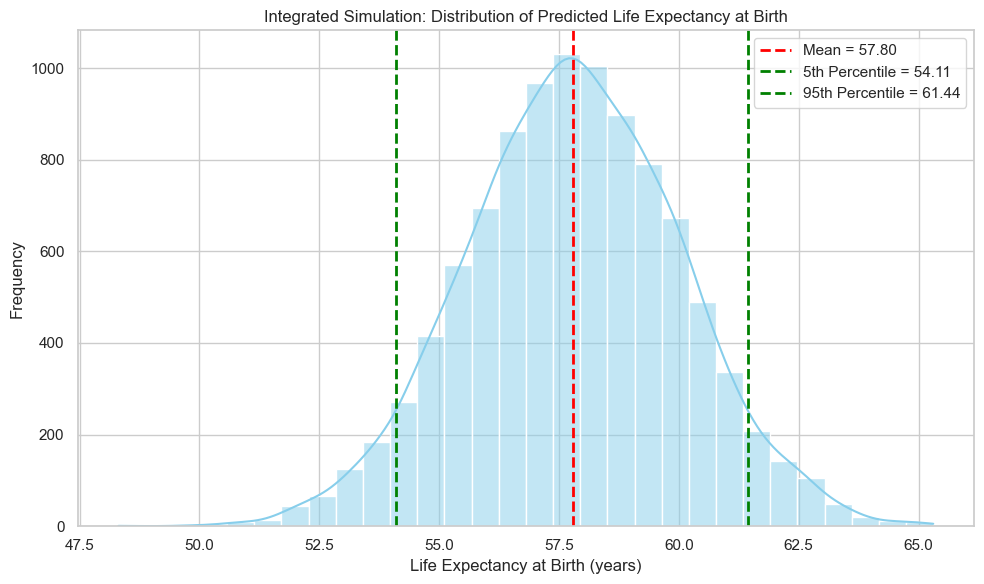

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

def integrated_simulation(n_sim=10000):
    """
    Integrated chain simulation:
      1. Sample socioeconomic predictor values from their multivariate distribution.
      2. Predict environmental outcomes using a regression equation based on socio indicators.
      3. Predict health outcomes based on the simulated environmental outcome.
      4. Predict Life Expectancy at Birth (LEB) using the simulated health outcome.
    
    In this example, simplified linear relationships and random coefficients are used.
    Replace these with your fitted model parameters as needed.
    
    Parameters:
    -----------
    n_sim : int
         Number of simulation iterations.
    
    Returns:
    --------
    simulated_LEB : ndarray
         Simulated Life Expectancy at Birth values.
    simulated_socio : ndarray
         Simulated socioeconomic predictor values.
    simulated_env : ndarray
         Simulated environmental outcome (aggregated).
    simulated_health : ndarray
         Simulated health outcome.
    """
    # --- Step 1: Socioeconomic Baseline ---
    # Assume X_train_socio (DataFrame of socio predictors; constant already dropped)
    # For demonstration, we simulate the socio predictor distribution using the empirical mean and covariance.
    # Replace this with your actual socio training data.
    # Here, we assume socio predictors are in a DataFrame called socio_df.
    # For example:
    # socio_df = X_train_socio.drop(columns="const")
    # For demonstration, we create a simple example socio dataset with 3 variables.
    num_socio_vars = 3
    socio_means = np.array([10, 20, 30])   # Example means
    socio_cov = np.diag([4, 9, 16])          # Example variances (covariances on the diagonal)
    
    simulated_socio = np.random.multivariate_normal(socio_means, socio_cov, size=n_sim)
    
    # --- Step 2: Environmental Simulation from Socio Data ---
    # Assume a regression model: 
    # simulated_env = intercept_env + beta_env.dot(socio)
    # For demonstration, we set:
    intercept_env = 5
    beta_env = np.array([0.3, 0.2, 0.1])   # Example coefficients
    simulated_env = intercept_env + simulated_socio.dot(beta_env)
    
    # --- Step 3: Health Outcome Simulation from Environmental Data ---
    # Assume a regression model: 
    # simulated_health = intercept_health + beta_health * simulated_env + error
    intercept_health = 60
    beta_health = 0.4
    # Add random noise with standard deviation 2
    simulated_health = intercept_health + beta_health * simulated_env + np.random.normal(0, 2, size=n_sim)
    
    # --- Step 4: Life Expectancy Prediction from Health Outcome ---
    # Assume a regression model:
    # simulated_LEB = intercept_LEB + beta_LEB * simulated_health + error
    intercept_LEB = 5
    beta_LEB = 0.8
    # Add random noise with standard deviation 1.5
    simulated_LEB = intercept_LEB + beta_LEB * simulated_health + np.random.normal(0, 1.5, size=n_sim)
    
    return simulated_LEB, simulated_socio, simulated_env, simulated_health

# Run the integrated simulation
simulated_LEB, simulated_socio, simulated_env, simulated_health = integrated_simulation(n_sim=10000)

# Summary Statistics for Life Expectancy Predictions
mean_LEB = np.mean(simulated_LEB)
p5_LEB = np.percentile(simulated_LEB, 5)
p95_LEB = np.percentile(simulated_LEB, 95)

print("Simulated Life Expectancy at Birth (LEB):")
print("Mean =", mean_LEB)
print("5th Percentile =", p5_LEB)
print("95th Percentile =", p95_LEB)

# --- Visualization with Seaborn ---

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(simulated_LEB, kde=True, bins=30, color="skyblue")
plt.title("Integrated Simulation: Distribution of Predicted Life Expectancy at Birth")
plt.xlabel("Life Expectancy at Birth (years)")
plt.ylabel("Frequency")
plt.axvline(mean_LEB, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_LEB:.2f}')
plt.axvline(p5_LEB, color='green', linestyle='--', linewidth=2, label=f'5th Percentile = {p5_LEB:.2f}')
plt.axvline(p95_LEB, color='green', linestyle='--', linewidth=2, label=f'95th Percentile = {p95_LEB:.2f}')
plt.legend()
plt.tight_layout()
plt.show()
